In [12]:
import pyrosm
import geopandas as gpd
import pandas as pd
import numpy as np
#import seaborn as sns
#from matplotlib import pyplot as plt
import contextily as cx
import gc
import utils

In [ ]:
# load openstreetmap basemap
# https://www.openstreetmap.org/export - boundingbox setup
bbox = [16.3837, 49.0946, 16.9227, 49.2884]  # [minx, miny, maxx, maxy]
pbf_reader = pyrosm.OSM('datasets/czech_republic-latest.osm.pbf', bounding_box=bbox)
cycling_network = pbf_reader.get_network('cycling')
driving_network = pbf_reader.get_network('driving')
basemap_network = driving_network.append(cycling_network)
del cycling_network
del driving_network
gc.collect()

# load strava data
strava_df = pd.read_csv('datasets/strava_edges_2021.csv')
# load bike-to-work data
biketowork_df = gpd.read_file('datasets/do_prace_na_kole.geojson')
# load mechanical counters data
counters_df = gpd.read_file('datasets/cyklodetektory.geojson')
# load driving census data
census_df = pd.read_excel('datasets/rsd_scitanie_dopravy_2020.xlsx', skiprows=[0])

In [ ]:
# drop unnecessary columns - speedup
strava_df = strava_df.drop([
    'forward_morning_trip_count',
    'reverse_morning_trip_count',
    'forward_evening_trip_count',
    'reverse_evening_trip_count',
    'forward_male_people_count',
    'reverse_male_people_count',
    'forward_female_people_count',
    'reverse_female_people_count',
    'forward_unspecified_people_count',
    'reverse_unspecified_people_count',
    'forward_13_19_people_count',
    'reverse_13_19_people_count',
    'forward_20_34_people_count',
    'reverse_20_34_people_count',
    'forward_35_54_people_count',
    'reverse_35_54_people_count',
    'forward_55_64_people_count',
    'reverse_55_64_people_count',
    'forward_65_plus_people_count',
    'reverse_65_plus_people_count',
    'activity_type',
    'year'
], axis=1)
# drop from counters
counters_df = counters_df.drop([
    'ID',
    'FirstDirection_Name',
    'FirstDirection_Pedestrians',
    'FirstDirection_Total',
    'SecondDirection_Name',
    'SecondDirection_Pedestrians',
    'SecondDirection_Total',
    'LocationId',
    'Latitude',
    'Longitude',
], axis=1)
counters_df

census_df = census_df[census_df['NÁZEV_MĚSTA'] == 'Brno']

In [ ]:
print(basemap_network.shape)
print(strava_df.shape)

## Match strava data to OSM basemap

In [ ]:
# create model from basemap and strava data
model = strava_df.join(basemap_network.set_index('id'), on='osm_reference_id', how='inner')
del basemap_network
del strava_df
gc.collect()
model = model.drop_duplicates()
# https://www.openstreetmap.org/way/{id}
print(model.shape)
model.head()

## Match mechanical counters to basemap

In [ ]:
# load distances between ways and mechanical counter units
counters = counters_df['geometry'].unique()
for i, item in enumerate(counters):
    # within <- exact match fails (needs threshold), better to use distance
    model[f'distance{i}'] = model['geometry'].apply(lambda x: x.distance(item))

counter_units = []
for counter_geo in counters:
    counter_units.append(counters_df[counters_df['geometry']==counter_geo]['UnitName'].unique()[0])

model.head()

In [ ]:
# check if counter street was found (OPTIONAL)
for i in range(len(counters)):
    print(f'Counter #{i}: ({counters_df[counters_df["geometry"]==counters[i]]["UnitName"].unique()[0]})')
    print(f'Lon: {counters[i].x}\nLat: {counters[i].y}')
    print(f'Closest way: {model[model[f"distance{i}"]==model[f"distance{i}"].min()]["osm_reference_id"].values}')

In [ ]:
# draw and save edges matched to counters
#fig = plt.figure(figsize=[20, 20], dpi=800)
#ax = plt.axes()
#fig.add_axes(ax)
unit_way_dict = {}
for i in range(len(counters)):
    min_dist = model[model[f"distance{i}"]==model[f"distance{i}"].min()]
    counter_matches = min_dist['geometry']
    geoser = gpd.GeoSeries(counter_matches)
    #geoser.plot(ax=ax)
    json_str = geoser.to_json()
    unit_way_dict[counter_units[i]] = min_dist['osm_reference_id'].unique()[0]
    #with open(f'counters_matching/counter{i}_matches.geojson', 'w+') as f:
    #    f.write(json_str)
# append edges to counters_df
counters_df['way_id'] = counters_df['UnitName'].map(unit_way_dict)
#counters_df.plot(ax=ax)
#cx.add_basemap(ax, crs=counters_df.crs, zoom=12)
#with open(f'counters_matching/counters.geojson', 'w+') as f:
#    f.write(gpd.GeoSeries(counters).to_json())

for i in range(len(counters)):
    model = model.drop([f'distance{i}'], axis=1)
counters_df.head()

In [ ]:
counters_df.to_file('counters_matched.geojson', driver="GeoJSON")

In [ ]:
# save final model
model.to_csv('model.csv', sep=';')
gpd.GeoDataFrame(model).to_file('model.geojson', driver="GeoJSON")

In [ ]:
model.to_pickle('model.pkl')

### From this point load model from pickle to skip setup

In [35]:
model = pd.read_pickle('model.pkl')

In [36]:
model_shrink = model.drop_duplicates(subset='osm_reference_id')
model_shrink['biketowork_gid'] = np.empty((len(model_shrink), 0)).tolist() # pd.Series([[] for _ in range(len(model_shrink))])
biketowork_df = gpd.read_file('datasets/do_prace_na_kole.geojson')
biketowork_shrink = biketowork_df.drop_duplicates(subset='GID_ROAD')

/tmp/ipykernel_26736/706342565.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_shrink['biketowork_gid'] = np.empty((len(model_shrink), 0)).tolist() # pd.Series([[] for _ in range(len(model_shrink))])


## Match model OSM basemap to biketowork ways
### (brute force N:N matching - VERY SLOW)

In [ ]:
for index, row in biketowork_df.iterrows():
    model_shrink['biketowork_gid'] = model_shrink.apply(lambda x: utils.assign_overlap(row, x['geometry'], x['biketowork_gid'], row['GID_ROAD']),
                                                        axis=1,)

In [ ]:
# osm=94635449 gid=224682
# osm=5606151 gid=224865  # NERUDOVA
# osm=8134289 gid=[224865.0]
# osm=33265238 gid=[224868.0]
model_shrink.to_csv('model_with_dpnk.csv', sep=';')
gpd.GeoDataFrame(model_shrink).to_file('model_with_dpnk.geojson', driver="GeoJSON")
model_shrink[['biketowork_gid', 'osm_reference_id']]

## Create map segment matrix

In [37]:
from itertools import pairwise

def generate_segments(bbox, num_of_segments):
    # X Segments
    degree_width = bbox[2] - bbox[0]
    segment_width = degree_width / num_of_segments
    start_minx = bbox[0]
    segment_mins_x = [start_minx + (segment_width*n) for n in range(NUM_OF_SEGMENTS+1)]
    # Y segments
    degree_height = bbox[3] - bbox[1]
    segment_heigth = degree_height / num_of_segments
    start_miny = bbox[1]
    segment_mins_y = [start_miny + (segment_heigth*n) for n in range(NUM_OF_SEGMENTS+1)]

    # create segment matrix
    segments_matrix = []
    y_pairs = pairwise(segment_mins_y)
    for y_limits in y_pairs:
        x_pairs = pairwise(segment_mins_x)
        for x_limits in x_pairs:
            segments_matrix.append((x_limits[0], y_limits[0], x_limits[1], y_limits[1]))

    return segments_matrix

bbox = (16.3837, 49.0946, 16.9227, 49.2884)  # [minx, miny, maxx, maxy]
NUM_OF_SEGMENTS = 20
segments_matrix = generate_segments(bbox, NUM_OF_SEGMENTS)

## Match model street to segment

In [38]:
def is_in_segment(row_bbox, segment):
    if row_bbox[0] < segment[0]:  # min X
        return False
    if row_bbox[1] < segment[1]:  # min Y
        return False
    if row_bbox[2] > segment[2]:  # max X
        return False
    if row_bbox[3] > segment[3]:  # max Y
        return False
    # print(f"segment: {segment}\nrow: {row_bbox}")
    return True

def assign_segments_to_dataset(dataset, segment_matrix, id_column):
    segment_ids = []
    street_ids = []
    for _, row in dataset.iterrows():
        row_bbox = row['geometry'].bounds
        # check every segment
        for index, segment in enumerate(segment_matrix):
            # save found segment and street ID
            if is_in_segment(row_bbox, segment):
                segment_ids.append(index)
                street_ids.append(row[id_column])
                break

    street_to_segment_df = pd.DataFrame({ id_column: street_ids, 'segment_id': segment_ids})
    return dataset.merge(street_to_segment_df, on=id_column)

model_shrink = assign_segments_to_dataset(model_shrink, segments_matrix, 'osm_reference_id')
biketowork_shrink = assign_segments_to_dataset(biketowork_shrink, segments_matrix, 'GID_ROAD')

In [39]:
model_shrink['segment_id'].value_counts()
biketowork_shrink['segment_id'].value_counts()

230    1191
188    1184
208    1170
247    1107
267    1095
       ... 
335       1
50        1
56        1
237       1
22        1
Name: segment_id, Length: 387, dtype: int64

<AxesSubplot:>

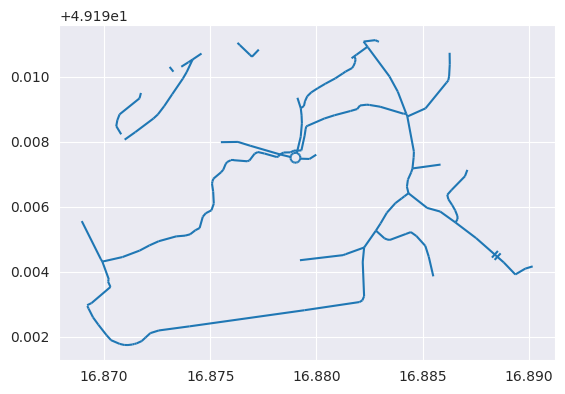

In [40]:
gpd.GeoDataFrame(model_shrink[model_shrink['segment_id'] == 218]).plot()

<AxesSubplot:>

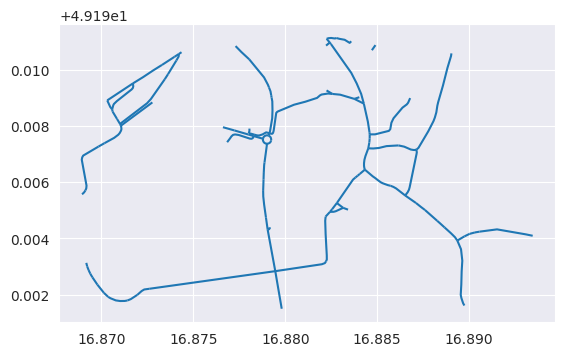

In [41]:
gpd.GeoDataFrame(biketowork_shrink[biketowork_shrink['segment_id'] == 218]).plot()

In [42]:
# try street matching per segment
for segm_id in range(len(segments_matrix)):
    model_segm = model_shrink[model_shrink['segment_id'] == segm_id].copy()
    model_segm['biketowork_gid'] = np.empty((len(model_segm), 0)).tolist()
    for index, row in biketowork_shrink[biketowork_shrink['segment_id'] == segm_id].iterrows():
        model_segm['biketowork_gid'] = model_segm.apply(lambda x: utils.assign_overlap(row, x['geometry'], x['biketowork_gid'], row['GID_ROAD']), axis=1,)
# TODO: not working ATM


ValueError: Columns must be same length as key